In [2]:
import numpy as np
import pickle
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [3]:
import sys
sys.path.append("../chembl_analyser/module/")
from calcula_tanimoto import *

In [4]:
from ddc_pub import ddc_v3 as ddc

In [5]:
import molvecgen

In [6]:
model_name = "models/pcb_model"
model = ddc.DDC(model_name=model_name)

Initializing model in test mode.
Loading model.


/home/alverad/anaconda3/envs/ddc_env/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator StandardScaler from version 0.20.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


'mol_to_latent_model' not found, setting to None.
Loading finished in 2 seconds.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Latent_Input (InputLayer)       [(None, 7)]          0                                            
__________________________________________________________________________________________________
Decoder_Inputs (InputLayer)     [(None, 142, 35)]    0                                            
__________________________________________________________________________________________________
latent_to_states_model (Model)  [(None, 256), (None, 18432       Latent_Input[0][0]               
__________________________________________________________________________________________________
batch_model (Model)             (None, 142, 35)      1364771     Decoder_Inputs[0][0]             
             

In [7]:
qsar_model_name = "models/qsar_model.pickle"
with open(qsar_model_name, "rb") as file:
    qsar_model = pickle.load(file)["classifier_sv"]

/home/alverad/anaconda3/envs/ddc_env/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator SVC from version 0.20.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [8]:
from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem, QED
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
#We suppres stdout from invalid smiles and validations
from rdkit import rdBase
rdBase.DisableLog ( 'rdApp.*')

In [9]:
def get_descriptors(mol):
    logp  = Descriptors.MolLogP(mol)
    tpsa  = Descriptors.TPSA(mol)
    molwt = Descriptors.ExactMolWt(mol)
    hba   = rdMolDescriptors.CalcNumHBA(mol)
    hbd   = rdMolDescriptors.CalcNumHBD(mol)
    qed   = QED.qed(mol)
     
                     
    # Calculate fingerprints
    fp = AllChem.GetMorganFingerprintAsBitVect(mol,2, nBits=2048)
    ecfp4 = np.zeros((2048,))
    DataStructs.ConvertToNumpyArray(fp, ecfp4) 
    # Predict activity and pick only the second component
    active_probability = qsar_model.predict_proba([ecfp4])[0][1]
    return [logp, tpsa, molwt, qed, hba, hbd, active_probability]

In [10]:
cruzain = pd.read_csv("chembl_smiles.csv")

In [11]:
cruzain = cruzain[['Molecule ChEMBL ID', 'Smiles']]

In [12]:
lista = []
for chembl, smiles in cruzain.to_numpy().tolist():
    lista.append([chembl, smiles] + get_descriptors(Chem.MolFromSmiles(smiles)))

In [14]:
data_cru_pro = pd.DataFrame(lista, columns=['chembl', 'smiles', "logp", "tpsa", "molwt", "qed", "hba", "hbd", "active_probability"])

In [15]:
data_cru_pro.sort_values(by='active_probability', ascending=False)

chembl                                             smiles    logp  \
562  CHEMBL4095194                        c1c[nH]c(CN2CCc3ccccc3C2)c1 2.57300   
88   CHEMBL3233099                    Cc1ccccc1OCCNCCc1nc2ccccc2[nH]1 3.08242   
541  CHEMBL4068608                             CN1CCN(Cc2ccc[nH]2)CC1 0.76210   
359  CHEMBL3623846   O=P(O)(O)[C@H](NC[C@@H]1CCCc2ccccc21)c1ccc(F)cc1 3.71170   
366  CHEMBL3291070  COc1cc(O)cc2c1[C@@H](/C=C/c1ccc(O)cc1)[C@@H]1[... 6.50120   
..             ...                                                ...     ...   
669  CHEMBL4082855                  O=C(CNc1ccnc2cc(Cl)ccc12)N1CCOCC1 2.15890   
247  CHEMBL3233108                 Cc1ccccc1OCC(=O)NCCC(=O)Nc1ccccc1O 2.22442   
334  CHEMBL3233106                  Cc1ccccc1OCC(=O)NCCC(=O)Nc1ccccc1 2.51882   
498  CHEMBL3104699   O=C1/C(=C/c2ccnc3ccccc23)CCC/C1=C\c1ccnc2ccccc12 6.00300   
566  CHEMBL3104699   O=C1/C(=C/c2ccnc3ccccc23)CCC/C1=C\c1ccnc2ccccc12 6.00300   

        tpsa     molwt     qed  hba  hbd  active_probability  
562 19.03000 212.13135 0.81030    1    1             0.71309  
88  49.94000 295.16846 0.65859    3    2             0.39986  
541 22.27000 179.14225 0.72391    2    1             0.35635  
359 69.56000 349.12431 0.71995    2    3             0.25387  
366 97.61000 524.18350 0.27412    7    3             0.11433  
..       ...       ...     ...  ...  ...                 ...  
669 54.46000 305.09310 0.94395    4    1             0.00000  
247 87.66000 328.14231 0.68020    4    3             0.00000  
334 67.43000 312.14739 0.82530    3    2             0.00000  
498 42.85000 376.15756 0.40282    3    0             0.00000  
566 42.85000 376.15756 0.40282    3    0             0.00000  

[715 rows x 9 columns]

In [16]:
data_cru_pro.loc[data_cru_pro.smiles.str.contains('#')]

chembl                                             smiles    logp  \
10    CHEMBL344174         N#CCNC(=O)[C@H](Cc1ccccc1)NC(=O)OCc1ccccc1 2.16388   
209   CHEMBL604281   CN(C#N)N(C)C(=O)[C@H](Cc1ccccc1)NC(=O)OCc1ccccc1 2.31038   
361  CHEMBL3233104            Cc1cc(C)c(C#N)c(SCCNC(=O)COc2ccccc2C)n1 3.16584   
411     CHEMBL6966  COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C... 5.09308   
483  CHEMBL4217658   N#CC1(NC(=O)[C@H](Cc2ccccc2)NC(=O)OCc2ccccc2)CC1 2.69648   
484  CHEMBL4212454  CN(C#N)N(C)C(=O)[C@H](Cc1ccccc1)NC(=O)c1cc(C(C... 1.84498   
554  CHEMBL3233084              N#Cc1ccccc1OCC(=O)NCCc1nc2ccccc2[nH]1 2.17228   
581  CHEMBL4217414  CC(C)C[C@H](NC(=O)c1cc(C(C)(C)C)nn1C)C(=O)N(C)... 1.64838   
682  CHEMBL4212989       CC(C)C[C@H](NC(=O)OC(C)(C)C)C(=O)N(C)N(C)C#N 1.71208   

        tpsa     molwt     qed  hba  hbd  active_probability  
10  91.22000 337.14264 0.75756    4    2             0.00008  
209 85.67000 366.16919 0.46167    5    1             0.00029  
361 75.01000 355.13545 0.60982    5    1             0.00005  
411 63.95000 454.28316 0.41990    6    0             0.00987  
483 91.22000 363.15829 0.79117    4    2             0.00027  
484 94.26000 396.22737 0.45679    6    1             0.00078  
554 90.80000 320.12733 0.72803    4    2             0.00109  
581 94.26000 362.24302 0.47164    6    1             0.00082  
682 85.67000 298.20049 0.47424    5    1             0.00036

In [17]:
smiles_target = data_cru_pro.loc[data_cru_pro.chembl == "CHEMBL91704"].smiles.to_numpy()[0]

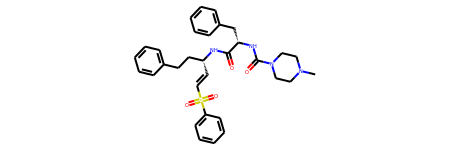

[3.659900000000002,
 98.82,
 574.261376696,
 0.36436025553250234,
 5,
 2,
 0.0002548531977814712]

In [18]:
mol = Chem.MolFromSmiles(smiles_target)
display(mol)
conditions = get_descriptors(mol)
conditions

In [19]:
target = np.array(conditions)
#smiles_out, _ = model.predict(latent=target, temp=1)
#Chem.MolFromSmiles(smiles_out)

In [20]:
#model.batch_input_length = 256
smiles_out = []
for i in range(10):
    smiles, _ = model.predict_batch(latent=target.reshape(1,-1), temp=1.0)
    smiles_out.append(smiles)
smiles_out = np.concatenate(smiles_out)
smiles_out.shape

InvalidArgumentError: No OpKernel was registered to support Op 'CudnnRNNV2' used by {{node Decoder_LSTM_0_2/CudnnRNNV2}}with these attrs: [seed=0, dropout=0, input_mode="linear_input", T=DT_FLOAT, direction="unidirectional", rnn_mode="lstm", is_training=true, seed2=0]
Registered devices: [CPU, XLA_CPU]
Registered kernels:
  device='GPU'; T in [DT_DOUBLE]
  device='GPU'; T in [DT_FLOAT]
  device='GPU'; T in [DT_HALF]

	 [[Decoder_LSTM_0_2/CudnnRNNV2]] [Op:__inference_keras_scratch_graph_5080]

In [21]:
mols = [Chem.MolFromSmiles(smi) for smi in smiles_out]

In [45]:
def sanitize(mol):
    try:
        Chem.SanitizeMol(mol)
        return mol
    except Exception as e:
        print(e)
         
sani_mols = [sanitize(mol) for mol in mols if mol != None]

In [46]:
len(sani_mols)

2263

In [47]:
len(sani_mols)/len(smiles_out)

0.883984375

In [ ]:
properties = [[Chem.MolToSmiles(mol)] + get_descriptors(mol) for mol in sani_mols if mol != None]
import pandas as pd
target_names = ["Smiles", "logp", "tpsa", "molwt", "qed", "hba", "hbd", "active_probability"]
data = pd.DataFrame(properties, columns=target_names)

In [ ]:
data.sort_values(by='active_probability', ascending=False)

In [ ]:
len(data)

In [23]:
len(data.loc[data.Smiles.str.contains('#')].sort_values(by='active_probability', ascending=False))

26

In [24]:
data.loc[data.Smiles.str.contains('#')].sort_values(by='active_probability', ascending=False)

Smiles    logp     tpsa     molwt     qed  \
504              CC#CCCC1c2ccccc2CCC1N 2.84720 26.02000 213.15175 0.75108   
531        C#CC(O)C1Cc2ccc(F)c3c2C1CC3 2.02190 20.23000 216.09504 0.71201   
254          NC1CC1c1cc(C#CC2CC2)ccc1F 2.40180 26.02000 215.11103 0.71517   
443      C#CCCN1CCc2c([nH]c3ccccc23)C1 2.54930 19.03000 224.13135 0.77669   
831         C#Cc1c[nH]c(C2CCCN2CCC)c1C 2.85132 19.03000 216.16265 0.76975   
1023     [C-]#[N+]C1CCNC2CCc3ccccc3C12 2.36619 16.39000 212.13135 0.65300   
1080         CC#CC(O)(CC)C1CCc2ccccc21 2.88080 20.23000 214.13577 0.75049   
557            C(#CCC1CCNCC1)Cc1ccccc1 2.62220 12.03000 213.15175 0.74466   
1059            C#CCC1(C)c2ccccc2CC1CC 3.54990  0.00000 198.14085 0.63746   
925         C#CC1c2c(ccc3ccccc23)CCC1N 2.83010 26.02000 221.12045 0.68010   
134    C#CC1=Cc2c(c(F)cc(O)c2C2CC2)CC1 3.37150 20.23000 228.09504 0.73052   
1124         CC#CC(O)C1CCc2cccc(F)c2C1 2.31480 20.23000 218.11069 0.71712   
428    CC#Cc1ccc2c3c([nH]c2c1)CC(C)N3C 2.92010 19.03000 224.13135 0.68165   
640           NC1C=C(CC#CCF)c2ccccc2C1 2.31640 26.02000 215.11103 0.71473   
201        C#CC1C(O)CC1CC1=Cc2ccccc2C1 2.64640 20.23000 224.12012 0.76565   
681         CC(C)=CC#Cc1ccc2c(c1)CCC2O 2.98390 20.23000 212.12012 0.65541   
536         OC1Cc2cc(C#Cc3ccccc3)ccc21 2.67590 20.23000 220.08882 0.67668   
741    C#Cc1ccc(Cc2c[nH]c(C3CC3)c2)cn1 2.85920 28.68000 222.11570 0.79472   
176       C#CCN1CC(c2ccc3cc[nH]c3c2)C1 2.20030 19.03000 210.11570 0.75284   
71           OC1CC(c2ccccc2C#CC2CC2)C1 2.68640 20.23000 212.12012 0.70955   
763            OC1CCC#CCc2cccc(Cl)c2C1 2.58310 20.23000 220.06549 0.66677   
444   C#CC1CC2CC(C1)C21Cc2[nH]cc(C)c21 2.79632 15.79000 211.13610 0.63511   
1039         N#CCc1cccc2c1CCc1ccccc1-2 3.51828 23.79000 219.10480 0.71955   
143          CCC#CC1(C(C)O)CCc2ccccc21 2.66480 20.23000 214.13577 0.71255   
377        C#CC1C2CCC(C2)C1c1ccc(O)cc1 3.15510 20.23000 212.12012 0.70890   
40           C#CC1(O)CCC(CCc2ccccc2)C1 2.78360 20.23000 214.13577 0.76705   

      hba  hbd  active_probability  
504     1    1             0.93543  
531     1    1             0.91334  
254     1    1             0.90898  
443     1    1             0.88039  
831     1    1             0.85300  
1023    1    1             0.78701  
1080    1    1             0.72270  
557     1    1             0.61686  
1059    0    0             0.57383  
925     1    1             0.50000  
134     1    1             0.47355  
1124    1    1             0.37431  
428     1    1             0.31871  
640     1    1             0.30937  
201     1    1             0.19120  
681     1    1             0.18485  
536     1    1             0.13392  
741     1    1             0.11519  
176     1    1             0.11130  
71      1    1             0.10349  
763     1    1             0.04945  
444     0    1             0.04486  
1039    1    0             0.02874  
143     1    1             0.02200  
377     1    1             0.01844  
40      1    1             0.01619

In [39]:
data_com_tanimoto = calcula_tanimoto(smiles_target, data, 4)

IndexError: list index out of range

Exception in thread Thread-13:
Traceback (most recent call last):
  File "../chembl_analyser/module/calcula_tanimoto.py", line 23, in calcula_tanimoto_module
    dados.append(float(f"{FingerprintSimilarity(mol, RDKFingerprint(MolFromSmiles(dados[index_smiles]))):.2f}"))
IndexError: list index out of range

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/alverad/anaconda3/envs/ddc_env/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/alverad/anaconda3/envs/ddc_env/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "../chembl_analyser/module/calcula_tanimoto.py", line 25, in calcula_tanimoto_module
    print(f"Error: {dados[index_smiles]}\n")
IndexError: list index out of range
Exception in thread Thread-11:
Traceback (most recent call last):
  File "../chembl_analyser/module/calcula_tanimoto.py", line 23, in calcula_tanimoto_module
 

In [104]:
alvos_cruzain = data.loc[data.Smiles.str.contains('#')].sort_values(by='active_probability', ascending=False).query("active_probability >= 0.5")
alvos_cruzain

Smiles    logp     tpsa     molwt     qed  hba  \
504           CC#CCCC1c2ccccc2CCC1N 2.84720 26.02000 213.15175 0.75108    1   
531     C#CC(O)C1Cc2ccc(F)c3c2C1CC3 2.02190 20.23000 216.09504 0.71201    1   
254       NC1CC1c1cc(C#CC2CC2)ccc1F 2.40180 26.02000 215.11103 0.71517    1   
443   C#CCCN1CCc2c([nH]c3ccccc23)C1 2.54930 19.03000 224.13135 0.77669    1   
831      C#Cc1c[nH]c(C2CCCN2CCC)c1C 2.85132 19.03000 216.16265 0.76975    1   
1023  [C-]#[N+]C1CCNC2CCc3ccccc3C12 2.36619 16.39000 212.13135 0.65300    1   
1080      CC#CC(O)(CC)C1CCc2ccccc21 2.88080 20.23000 214.13577 0.75049    1   
557         C(#CCC1CCNCC1)Cc1ccccc1 2.62220 12.03000 213.15175 0.74466    1   
1059         C#CCC1(C)c2ccccc2CC1CC 3.54990  0.00000 198.14085 0.63746    0   
925      C#CC1c2c(ccc3ccccc23)CCC1N 2.83010 26.02000 221.12045 0.68010    1   

      hbd  active_probability  
504     1             0.93543  
531     1             0.91334  
254     1             0.90898  
443     1             0.88039  
831     1             0.85300  
1023    1             0.78701  
1080    1             0.72270  
557     1             0.61686  
1059    0             0.57383  
925     1             0.50000

In [90]:
smiles = data.loc[data.Smiles.str.contains('#')].sort_values(by='active_probability', ascending=False).query("active_probability >= 0.5").Smiles
prob = data.loc[data.Smiles.str.contains('#')].sort_values(by='active_probability', ascending=False).query("active_probability >= 0.5").active_probability

In [91]:
smiles = smiles.to_numpy().tolist()
prob = [f"{prob*100:0.2f}%" for prob in prob.to_numpy().tolist()]

In [92]:
mols = [Chem.MolFromSmiles(smile) for smile in smiles]

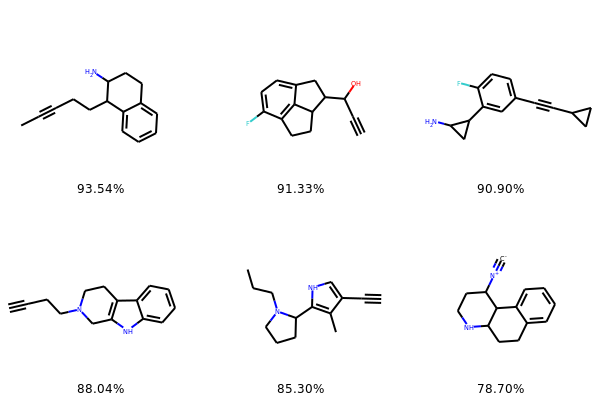

In [94]:
Chem.Draw.MolsToGridImage(mols[:6], legends=prob[:6])

In [47]:
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_with_prob]

In [ ]:
mols

[None, None, None, None, None, None, None, None, None, None]

In [ ]:
Chem.Dr

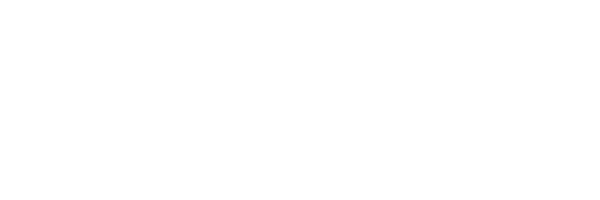

In [49]:
Chem.Draw.MolsToGridImage(mols[:3])

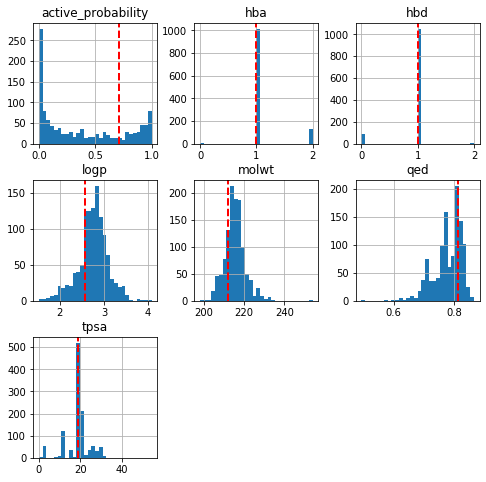

In [14]:
target_dict = {t[0]:t[1] for t in zip(data.columns, ["c1c[nH]c(CN2CCc3ccccc3C2)c1"] + conditions)}
axes = data.hist(bins=30,figsize=(8,8))
for i, ax in enumerate(axes.flatten()):
    title = ax.title.__dict__["_text"]
    if title:
        ax.axvline(x=target_dict[title], color='r', linestyle='dashed', linewidth=2)

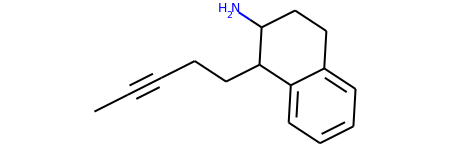

In [16]:
Chem.MolFromSmiles("CC#CCCC1c2ccccc2CCC1N")

In [9]:
import sqlite3

In [10]:
con = sqlite3.connect("../chembl/data/propriedades.db")

In [11]:
#data.to_sql("novos_ligantes", con, index=False, if_exists="replace")

NameError: name 'data' is not defined

In [12]:
data = pd.read_sql("select * from novos_ligantes", con)

In [98]:
data

Smiles    logp     tpsa     molwt     qed  \
0          c1cc2ccc(CCN3CCCC3)cc2[nH]1 2.80620 19.03000 214.14700 0.83208   
1      Cc1cc(C)c2[nH]cc(C3CN(C)C3)c2c1 2.81374 19.03000 214.14700 0.77309   
2     Cc1ccc(C2=CC3CCC(C2)N(C)C3)[nH]1 2.82062 19.03000 216.16265 0.76453   
3             CN1CCCC(Cc2cc[nH]c2Cl)C1 2.55240 19.03000 212.10803 0.79863   
4              CN(Cc1ccccc1)C1CCCCC1CN 2.63590 29.26000 232.19395 0.86443   
...                                ...     ...      ...       ...     ...   
1147          CCC12CC(Cc3ccccc31)CC2CO 2.90900 20.23000 216.15142 0.80561   
1148        NCCc1cccc(C23CC(F)CC2C3)c1 2.57740 26.02000 219.14233 0.83044   
1149        OCC1C2CCC1C(c1cccc(F)c1)C2 2.94770 20.23000 220.12634 0.81208   
1150      CCc1ccc(C23CNCC(C2)C3)c(C)c1 2.80842 12.03000 215.16740 0.79965   
1151     CN(C)C1CCc2c([nH]c3ccccc23)C1 2.58680 19.03000 214.14700 0.77277   

      hba  hbd  active_probability  
0       1    1             0.60566  
1       1    1             0.26839  
2       1    1             0.84021  
3       1    1             0.31522  
4       2    1             0.00766  
...   ...  ...                 ...  
1147    1    1             0.07655  
1148    1    1             0.20460  
1149    1    1             0.00782  
1150    1    1             0.01256  
1151    1    1             0.91089  

[1152 rows x 8 columns]

In [95]:
data_2 = pd.read_sql("select * from dados", con)

In [101]:
data_2

chembl_id  mw_freebase   alogp       psa      rtb  cx_most_apka  \
0         CHEMBL287510    357.45400 1.51190  73.83000 10.00000           nan   
1         CHEMBL285301    320.43300 1.71240  70.59000  9.00000           nan   
2         CHEMBL285413    255.31400 1.41230  48.95000  8.00000           nan   
3          CHEMBL24475    262.34900 3.64890  46.53000  8.00000       9.95000   
4          CHEMBL24545    330.46800 4.45000  43.37000  2.00000           nan   
...                ...          ...     ...       ...      ...           ...   
2084583  CHEMBL4110107    507.53800 4.47270 105.57000  8.00000      11.72000   
2084584  CHEMBL4110108    337.33500 3.03200  76.68000  2.00000      11.84000   
2084585  CHEMBL4110109    338.78500 4.11530  41.99000  7.00000           nan   
2084586  CHEMBL4110110    480.96800 3.12660  96.81000 10.00000           nan   
2084587  CHEMBL4110111    524.50700 3.84110 134.30000  4.00000       8.65000   

         cx_most_bpka  cx_logp  cx_logd molecular_species  full_mwt  \
0             8.79000  1.80000  0.40000              BASE 357.45000   
1             8.79000  1.96000  0.55000              BASE 320.43000   
2             7.42000  1.45000  1.14000           NEUTRAL 255.31000   
3                 nan  4.40000  4.40000           NEUTRAL 262.35000   
4                 nan  4.21000  4.21000           NEUTRAL 330.47000   
...               ...      ...      ...               ...       ...   
2084583       3.32000  3.13000  3.13000           NEUTRAL 507.54000   
2084584       5.74000  2.11000  2.10000           NEUTRAL 337.34000   
2084585       7.09000  3.66000  3.49000           NEUTRAL 338.79000   
2084586       3.97000  3.19000  3.19000           NEUTRAL 480.97000   
2084587       4.94000  2.06000  2.04000           NEUTRAL 524.51000   

         aromatic_rings  heavy_atoms  qed_weighted  mw_monoisotopic  \
0               2.00000     26.00000       0.56000        357.20520   
1               2.00000     23.00000       0.61000        320.21000   
2               1.00000     18.00000       0.71000        255.14710   
3               1.00000     19.00000       0.57000        262.15690   
4               4.00000     24.00000       0.70000        330.21950   
...                 ...          ...           ...              ...   
2084583         4.00000     35.00000       0.47000        507.15520   
2084584         5.00000     25.00000       0.78000        337.10630   
2084585         2.00000     23.00000       0.77000        338.09970   
2084586         3.00000     33.00000       0.54000        480.19400   
2084587         6.00000     38.00000       0.37000        524.18960   

         hba_lipinski  hbd_lipinski  num_lipinski_ro5_violations  \
0             5.00000       3.00000                      0.00000   
1             4.00000       3.00000                      0.00000   
2             5.00000       1.00000                      0.00000   
3             3.00000       1.00000                      0.00000   
4             3.00000       0.00000                      0.00000   
...               ...           ...                          ...   
2084583       7.00000       2.00000                      1.00000   
2084584       5.00000       1.00000                      0.00000   
2084585       3.00000       1.00000                      0.00000   
2084586       7.00000       2.00000                      0.00000   
2084587       7.00000       3.00000                      1.00000   

                                          canonical_smiles  
0                    CN(C)c1ccccc1C(=O)NCCNCC(O)COc1ccccc1  
1                         O=C(NCCNCC(O)COc1ccccc1)C1CCCCC1  
2                               COc1ccc(OC)c(CNCC(OC)OC)c1  
3                          CCCC/C=C/C(=O)CCc1ccc(O)c(OC)c1  
4                  CCC(=O)OC1CCC2C3CCC4=CC(=O)CCC4C3CCC12C  
...                                                    ...  
2084583  Cc1cc(N=S2(=O)CCC2)cc2ncnc(Nc3ccc(F)cc3O[C@H](...  
2084584    O=C1OC[C@H](c2ccc3c(c2)OCCO3)N

In [105]:
data_2.query("canonical_smiles in @alvos_cruzain.Smiles")

Empty DataFrame
Columns: [chembl_id, mw_freebase, alogp, psa, rtb, cx_most_apka, cx_most_bpka, cx_logp, cx_logd, molecular_species, full_mwt, aromatic_rings, heavy_atoms, qed_weighted, mw_monoisotopic, hba_lipinski, hbd_lipinski, num_lipinski_ro5_violations, canonical_smiles]
Index: []